# Performance comparison

In [4]:
import os
import random
import yaml
import re
import torch


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta


# set random seed
seed = 42
np.random.seed(seed)
random.seed(seed)


## Load

In [5]:
experiment_folder_name = '1_model_complexity'
experiment_folder = MODELS_DIR / experiment_folder_name

split = 0 # first split
relative_path = f'{split+1}_split/'

# folder to save the plots
plots_folder = FIGURES_DIR / 'experiments' / experiment_folder_name
plots_folder.mkdir(exist_ok=True, parents=True)



In [6]:

# Dictionary to store the results
runs = {}

experiment_names = [] # handle duplicates
lowest_steps_ahead = np.inf # ensure no index error
# iterate each run
for experiment_name in sorted(os.listdir(experiment_folder)):
    if experiment_name.startswith('.'):
        print(f'Skipping {experiment_name}')
        continue

    try:
        results = {}
        save_folder = MODELS_DIR / experiment_folder_name / experiment_name

        run_folder = save_folder / relative_path
        eval_folder = run_folder / 'evaluation'

        # Get relevant indo
        config = yaml.load(open(save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)
        try:
            # load pkl with cpu
            split_info = torch.load(save_folder / 'split_info.pkl', map_location='cpu')
            run_info = split_info[split]
            #  if the best_model_path, last_model_path, top_k_best_model_paths are not relative paths, then convert them to relative paths
            #if not os.path.isabs(run_info['best_model_path']):
            if '/' in run_info['best_model_path']:
                run_info['best_model_path'] = os.path.relpath(run_info['best_model_path'], run_folder)
                run_info['last_model_path'] = os.path.relpath(run_info['last_model_path'], run_folder)
                run_info['top_k_best_model_paths'] = {
                    k: os.path.relpath(str(v), run_folder) for k, v in run_info['top_k_best_model_paths'].items()
                }
        except Exception as e:
            run_info = {
                'best_model_path': 'epoch=0',
                'training_time': 0
            }
        
        # run_folder = Path(config['split_folders'][split])
        # run_info = split_info[split]    
        # eval_folder = run_folder / 'evaluation'

        # Load the split info
        best_model_path = run_info['best_model_path']
        epoch = int(re.search(r'epoch=(\d+)', best_model_path).group(1))
        results['epoch'] = epoch
        results['training_time'] = run_info['training_time']
        
        # Handle the experiment name (in case of duplicates)
        #experiment_name = config['experiment_name']
        
        
        # Remove the date formatting of the experiment name
        if '_' in experiment_name:
            experiment_name = '_'.join(experiment_name.split('_')[:-2])


        if experiment_name not in experiment_names:
            results['experiment_name'] = experiment_name
            experiment_names.append(experiment_name)
        else:
            print(f'Warning: {experiment_name} already exists')
            experiment_names.append(experiment_name)
            # count occurrences of name
            count = sum([1 for name in experiment_names if name == experiment_name])
            experiment_name = f'{experiment_name} ({count})'
            results['experiment_name'] = experiment_name


        data_types = ['val', 'test']
        for data_type in data_types:
            results[data_type] = {}
            step_MAEs = pd.read_csv(eval_folder / data_type / 'step_MAEs.csv', index_col=0)
            results[data_type]['step_MAEs'] = step_MAEs
            condition_MAEs = pd.read_csv(eval_folder / data_type / 'condition_MAEs.csv', index_col=[0, 1])
            results[data_type]['condition_MAEs'] = condition_MAEs
        
        # get the lowest steps ahead
        lowest_steps_ahead = min(lowest_steps_ahead, max(step_MAEs.index))
        runs[experiment_name] = results
        print(f'Loaded {experiment_name}')  

    except Exception as e:
        print(f'Error loading {experiment_name}: {e}')
        continue


print(f'Lowest steps ahead: {lowest_steps_ahead}')

Loaded hidden_size=128_num_heads=1_num_layers=1
Loaded hidden_size=128_num_heads=2_num_layers=2
Error loading hidden_size=128_num_heads=4_num_layers=2: [Errno 2] No such file or directory: '/work3/s194262/GitHub/fault_management_uds/models/1_model_complexity/hidden_size=128_num_heads=4_num_layers=2_241222_1215/1_split/evaluation/val/step_MAEs.csv'
Loaded hidden_size=32_num_heads=1_num_layers=1
Loaded hidden_size=32_num_heads=2_num_layers=2
Loaded hidden_size=64_num_heads=1_num_layers=1
Error loading hidden_size=64_num_heads=2_num_layers=2: [Errno 2] No such file or directory: '/work3/s194262/GitHub/fault_management_uds/models/1_model_complexity/hidden_size=64_num_heads=2_num_layers=2_241222_1120/1_split/evaluation/val/step_MAEs.csv'
Error loading hidden_size=64_num_heads=4_num_layers=2: [Errno 2] No such file or directory: '/work3/s194262/GitHub/fault_management_uds/models/1_model_complexity/hidden_size=64_num_heads=4_num_layers=2_241222_1215/1_split/evaluation/val/step_MAEs.csv'
Lowes

## 1 step ahead

In [18]:
data_type = 'val'

In [19]:
# create the dataframe
data = []

round_to = 5
for run in runs:
    experiment_name = runs[run]['experiment_name']
    step_MAEs = runs[run][data_type]['step_MAEs']
    data.append({
        #'run': run,
        'Experiment': f"{experiment_name}",
        '1-step MAE': step_MAEs.loc[1, 'Overall'],
        #'date': run,
    })

df = pd.DataFrame(data)
df = df.sort_values(by='1-step MAE', ascending=True)
# now round
df = df.round(round_to)
df

,Experiment,1-step MAE
1,hidden_size=128_num_heads=2_num_layers=2,0.00228
3,hidden_size=32_num_heads=2_num_layers=2,0.00239
2,hidden_size=32_num_heads=1_num_layers=1,0.00254
4,hidden_size=64_num_heads=1_num_layers=1,0.00256
0,hidden_size=128_num_heads=1_num_layers=1,0.00257


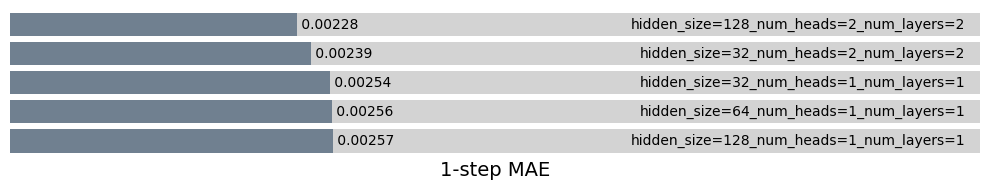

In [20]:
# plot the results
plt.figure(figsize=(10, 2))
# the highest value should be 1/3 of the bar width (to leave space for the text)
highest_value = df['1-step MAE'].max()
ax = sns.barplot(data=df, y='Experiment', x=[highest_value*3] * len(df), color='lightgrey', saturation=1) # create the background bars
sns.barplot(data=df, y='Experiment', x='1-step MAE', color='slategrey', saturation=1, ax=ax)

for lbl in ax.get_yticklabels():
     # add the y tick labels as right aligned text into the plot
     ax.text(0.985, lbl.get_position()[1], lbl.get_text(), transform=ax.get_yaxis_transform(), ha='right', va='center')
ax.bar_label(ax.containers[1], fmt=f' %.{round_to}f', label_type='edge') # add the values on the right side of the bars
ax.set_xticks([]) # remove the x ticks
ax.set_yticks([]) # remove the y ticks
ax.set_ylabel('') # remove the y label
#ax.xaxis.label.set_visible(False)
ax.xaxis.set_label('1-step MAE')
# adjust size of the x axis
ax.xaxis.label.set_size(14)
ax.margins(x=0) # remove the spacing at the right
sns.despine(left=True, bottom=True) # remove the spines
plt.tight_layout()
# save the plot
plt.savefig(plots_folder / 'overall_1_step_MAE.png', dpi=150)
plt.show()


In [21]:
# remove 

## MAE as a function of steps ahead

In [22]:
# create the dataframe
data = np.zeros((lowest_steps_ahead, len(runs))) # (experiments, steps ahead) similar to (rows, columns)

round_to = 5
for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    step_MAEs = runs[run][data_type]['step_MAEs']
    data[:, i] = step_MAEs['Overall'].values

df = pd.DataFrame(data, columns=[f"{runs[run]['experiment_name']}" for run in runs], index=range(1, lowest_steps_ahead+1))
# sort columns by lowest 1-step MAE
df = df[df.loc[1].sort_values().index]
df

,hidden_size=128_num_heads=2_num_layers=2,hidden_size=32_num_heads=2_num_layers=2,hidden_size=32_num_heads=1_num_layers=1,hidden_size=64_num_heads=1_num_layers=1,hidden_size=128_num_heads=1_num_layers=1
1,0.002282,0.002387,0.002541,0.002564,0.002566
2,0.002558,0.002646,0.002812,0.002822,0.002925
3,0.002883,0.002980,0.003124,0.003151,0.003393
4,0.003210,0.003345,0.003475,0.003507,0.003931
5,0.003522,0.003708,0.003817,0.003864,0.004490
6,0.003824,0.004061,0.004176,0.004220,0.005070
7,0.004119,0.004403,0.004542,0.004590,0.005666
8,0.004410,0.004730,0.004913,0.004955,0.006258
9,0.004700,0.005048,0.005303,0.005331,0.006852
10,0.004992,0.005357,0.005678,0.005702,0.007439


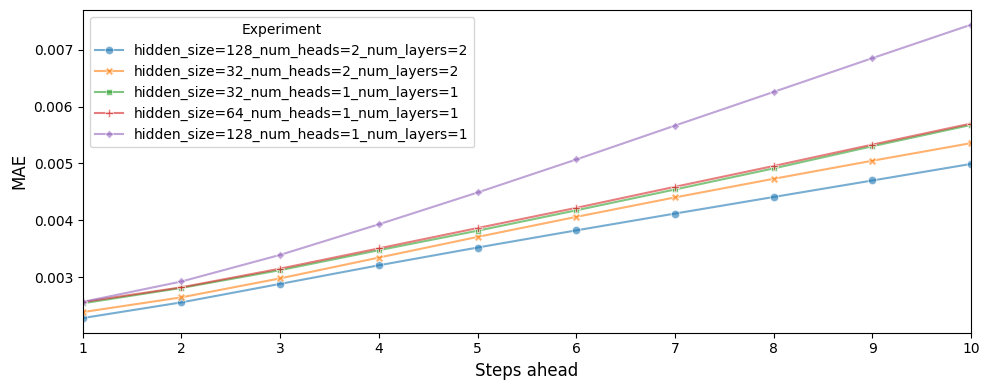

In [23]:
# Visualize the MAEs
plt.figure(figsize=(10, 4))
# plot the MAEs
sns.lineplot(data=df, alpha=0.6, dashes=False, markers=True)
plt.xticks(range(1, lowest_steps_ahead+1))
plt.xlim(1, lowest_steps_ahead)
plt.legend(loc='upper left', fontsize=10, title='Experiment')
plt.xlabel('Steps ahead', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.tight_layout()
# save the plot
plt.savefig(plots_folder / 'overall_steps_ahead_MAE.png', dpi=150)
plt.show()


## Conditions and 1 step ahead

In [24]:
# create the dataframe
df = pd.DataFrame()

for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    condition_MAEs = runs[run][data_type]['condition_MAEs']
    condition_1_step_overall = condition_MAEs.loc[1, ['Overall']].rename(columns={'Overall': experiment_name}).T
    df = pd.concat([df, condition_1_step_overall])

n_conditions = df.shape[1]
# sort rows by overall 1-step MAE column
df = df.sort_values(by='Overall', axis=0)
df

Condition,Overall,Rain,Extreme,Dry
hidden_size=128_num_heads=2_num_layers=2,0.002282,0.003171,0.003612,0.002112
hidden_size=32_num_heads=2_num_layers=2,0.002387,0.003265,0.003623,0.002211
hidden_size=32_num_heads=1_num_layers=1,0.002541,0.003508,0.003958,0.002366
hidden_size=64_num_heads=1_num_layers=1,0.002564,0.003630,0.004034,0.002371
hidden_size=128_num_heads=1_num_layers=1,0.002566,0.003438,0.003790,0.002408


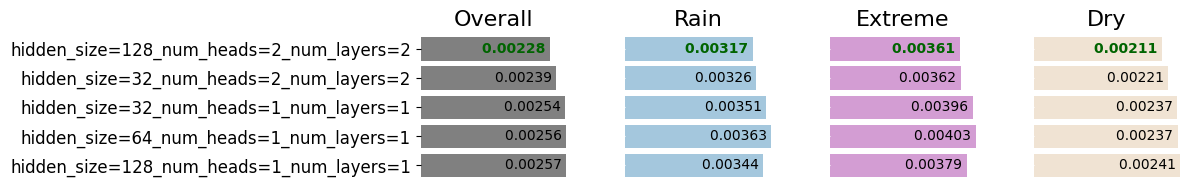

In [25]:
# Create a figure with an additional column for averages
fig, axs = plt.subplots(1, n_conditions, figsize=(12, 2))

for i, condition in enumerate(df.columns):
    axs[i] = sns.barplot(data=df, y=df.index, x=condition, ax=axs[i], saturation=0.5, color = condition_to_meta[condition]['color'])
    # add tooltips
    lowest_value = df[condition].min()
    for j, value in enumerate(df[condition]):
        color = 'black' if value != lowest_value else 'darkgreen'
        fontweight = 'normal' if value != lowest_value else 'bold'
        axs[i].text(value, j, f'{value:.{round_to}f} ', ha='right', va='center', fontsize=10, color=color, fontweight=fontweight)

    axs[i].set_title(condition, fontsize=16)
    axs[i].tick_params(axis='y', labelsize=12) if i == 0 else axs[i].tick_params(axis='y', labelsize=1, colors='white')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_xticks([])
    axs[i].margins(x=0)
    sns.despine(ax=axs[i], left=True, bottom=True)

plt.tight_layout()
plt.savefig(plots_folder / 'condition_1_step_MAE.png', dpi=150)
plt.show()


## Training time and epochs

In [26]:
runs[run][data_type]['step_MAEs'].loc[1, 'Overall']

0.0025637825621215

In [27]:
# create the dataframe
df = pd.DataFrame()

for i, run in enumerate(runs):
    experiment_name = runs[run]['experiment_name']
    epochs = runs[run]['epoch']
    training_time = runs[run]['training_time']
    _df = pd.DataFrame({
        'Experiment': experiment_name,
        'Epochs': epochs,
        'Training time': training_time,
        'Overall': runs[run][data_type]['step_MAEs'].loc[1, 'Overall']
    }, index=[experiment_name])

    df = pd.concat([df, _df])

# sort rows by overall 1-step MAE column
df = df.sort_values(by='Overall')
# set experiment as index
df = df.set_index('Experiment')
n_conditions = df.shape[1]
df

,Epochs,Training time,Overall
Experiment,,,
hidden_size=128_num_heads=2_num_layers=2,13,356.421111,0.002282
hidden_size=32_num_heads=2_num_layers=2,8,352.666282,0.002387
hidden_size=32_num_heads=1_num_layers=1,0,106.347950,0.002541
hidden_size=64_num_heads=1_num_layers=1,1,124.175947,0.002564
hidden_size=128_num_heads=1_num_layers=1,2,172.289923,0.002566


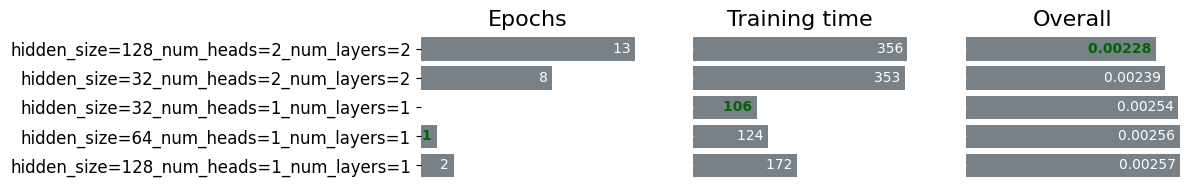

In [28]:
# Create a figure with an additional column for averages
fig, axs = plt.subplots(1, n_conditions, figsize=(12, 2))

for i, condition in enumerate(df.columns):
    sns.barplot(data=df, y=df.index, x=condition, ax=axs[i], saturation=0.5, color = 'slategrey')
    # add tooltips
    # Add tooltips on the opposite side of the bars
    lowest_value = df[condition].min()
    lowest_value = lowest_value if lowest_value != 0 else df[condition].sort_values().iloc[1]
    for j, value in enumerate(df[condition]):
        color = 'white' if value != lowest_value else 'darkgreen'
        fontweight = 'normal' if value != lowest_value else 'bold'
        round_to = 5 if condition == "Overall" else 0
        axs[i].text(value, j, f'{value:.{round_to}f} ', ha='right', va='center', fontsize=10, color=color, fontweight=fontweight)
    axs[i].set_title(condition, fontsize=16)
    axs[i].tick_params(axis='y', labelsize=12) if i == 0 else axs[i].tick_params(axis='y', labelsize=1, colors='white')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_xticks([])
    axs[i].margins(x=0)
    sns.despine(ax=axs[i], left=True, bottom=True)

plt.tight_layout()
plt.savefig(plots_folder / 'parameters_1_step_MAE.png', dpi=150)
plt.show()


TODO: and parameters??
